In [171]:
# default_exp feature_eng

In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
# export
from mlfinlab.microstructural_features import (
    get_roll_measure,
    get_roll_impact,
    get_bar_based_kyle_lambda,
    get_bar_based_amihud_lambda,
)
from mlfinlab.microstructural_features.entropy import (
    get_shannon_entropy,
    get_lempel_ziv_entropy,
    get_plug_in_entropy,
    get_konto_entropy
)
from mlfinlab.structural_breaks import get_sadf


from copy import deepcopy
import pandas as pd
import numpy as np
import logging
import string
from mlbt.load_data import load_feat, save_feat
from mlbt.frac_diff import frac_diff_ffd
from mlbt.load_data import get_data, SYMBOLS_CSV, safe_feat_name, process_bars
SYMBOLS_CSV = SYMBOLS_CSV.copy()
SYMBOLS_CSV.columns = SYMBOLS_CSV.columns.str.lower()
SYMBOLS_DICT = SYMBOLS_CSV.T.to_dict()


def roll_measure(df, window, price="Close"):
    """The Roll measure attempts to estimate the bid-ask spread (i.e. liquidity) of an instrument"""
    return get_roll_measure(df[price], window)


def roll_impact(df, window, price="Close", dollar_volume="Dollar Volume"):
    """The Roll measure divided by dollar volume"""
    return roll_measure(df, window, price) / df[dollar_volume] * 1e9


def kyle(df, window, price="Close", volume="Volume"):
    """A measure of market impact cost (i.e. liquidity) from Kyle (1985)"""
    return get_bar_based_kyle_lambda(df[price], df[volume], window) * 1e9


def amihud(df, window, price="Close", dollar_volume="Dollar Volume"):
    """A measure of market impact cost (i.e. liquidity) from Amihud (2002)"""
    return get_bar_based_amihud_lambda(df[price], df[dollar_volume], window) * 1e9


def autocorr(df, window, lag, column="Close"):
    """The raw price series' serial correlation"""
    return df[column].rolling(window).apply(lambda x: x.autocorr(lag=lag), raw=False)


def corr(df, window, other, column="Close"):
    return df[column].rolling(window).corr(other)


def rolling_stdev(df, window, column="Close"):
    """The series' rolling standard deviation"""
    return df[column].rolling(window).std()


def rolling_max(df, window, column="Close"):
    return df[column].rolling(window).max()


def rolling_mean(df, window, column="Close"):
    return df[column].rolling(window).mean()


def ewm_stdev(df, window, column="Close"):
    return df[column].ewm(com=window).std()


def ewm_mean(df, window, column="Close"):
    return df[column].ewm(com=window).mean()


def int_ret(df, periods=1, column="Close"):
    """First difference of log-transformed prices"""
    return df[column].pct_change(periods=periods)


def log_ret(df, periods=1, column="Close"):
    """First difference of log-transformed prices"""
    return np.log(df[column]).diff(periods=periods)


def ffd(df, d, column="Close"):
    """Fractionally differentiated prices"""
    return frac_diff_ffd(np.log(df[column].to_frame('Close')), d)['Close']


def volratio(df, volume="Volume", buy_volume="Buy Volume"):
    """
    EWM of bar-by-bar buy volume divided by total volume
    (i.e. a value >0.50 would indicate buyers driving the market)
    """
    return df[buy_volume] / df[volume]


def binary_encoding(returns):
    return np.sign(returns).map({-1: 'a', 1: 'b'})


def quantile_encoding(returns, q=10):
    return pd.qcut(returns, q=q, labels=list(string.printable[:q]), duplicates='drop')


def sigma_encoding(returns):
    stdev = returns.std()

    nbins = int((returns.max() - returns.min()) / stdev)
    min_ = returns.min()

    bins = pd.IntervalIndex.from_tuples([
        (
            min_+ (stdev * i), min_+ (stdev * (i + 1))
        ) for i in range(nbins + 1)
    ])
    x = pd.cut(returns, bins)

    mapper = dict(zip(bins, list(string.printable)[:nbins]))
    sigma_q = x.values.map(mapper)
    return pd.Series(sigma_q, index=returns.index)    

ENCODERS = {
    'binary': binary_encoding,
    'quantile': quantile_encoding,
    'sigma': sigma_encoding,
}


ENTROPY_FUNS = {
    'shannon': get_shannon_entropy,
    'plugin': get_plug_in_entropy,
    'konto': get_konto_entropy,
    'lz': get_lempel_ziv_entropy,
}

def entropy(df, method, encoding, window, column="Close", konto_len=None):
    encoder = ENCODERS[encoding]
    entropy_fun = ENTROPY_FUNS[method]
    kwargs = {"window": konto_len} if konto_len is not None else {}
#     apply_entropy = lambda x, fun:
    debug = lambda x: x
    encoded = encoder(df[column]).dropna()
    rolling = encoded.rolling(window)


#     df = pd.DataFrame({'col1':list('some_string')})
#     window = 5
    ss = pd.Series([
        ''.join(encoded.values[max(i-window+1, 0): i+1])
        for i in range(len(encoded.values))
    ])
    
    entropies = ss.apply(lambda x: entropy_fun(x, **kwargs))
    entropies.index = encoded.index

    entropies[:window-1]=np.nan
    assert entropies.index.is_unique
    return entropies


def close(df, column="Close"):
    return df[column]


def lag(df, lag, column="Close"):
    return df[column].shift(lag)


def lag_change(df, lag, column="Close"):
    return df[column].pct_change(lag)


def lag_diff(df, lag, column="Close"):
    col = df[column]
    return col - col.shift(lag)


def sadf(df, model="linear", min_length=20, lags=5, column="Close"):
    return get_sadf(df[column], model=model, add_const=True, min_length=min_length, lags=lags, num_threads=1)

    
# Dates
def month(df, column="Time"):
    return df[column].dt.month


def week(df, column="Time"):
    return df[column].dt.week

    
def day(df, column="Time"):
    return df[column].dt.day

    
def weekday(df, column="Time"):
    return df[column].dt.weekday

    
def hour(df, column="Time"):
    return df[column].dt.hour


def tick_bars(df, size, column="Close"):
    return process_bars(df, size, type_="tick")[column]


def make_bars(df, type_, size, resolution="MIN", column="Close"):
    return process_bars(df, size, type_, resolution)[column]

    
FEATURES = {
    "auto": autocorr,
    "corr": corr,
    "rolling_stdev": rolling_stdev,
    "rolling_mean": rolling_mean,
    "rolling_max": rolling_max,
    "ewm_stdev": ewm_stdev,
    "ewm_mean": ewm_mean,
    "roll": roll_measure,
    "rollimp": roll_impact,
    "kyle": kyle,
    "amihud": amihud,
    "volratio": volratio,
    "entropy": entropy,
    "int_ret": int_ret,
    "log_ret": log_ret,
    "ffd": ffd,
    "close": close,
    "lag": lag,
    "lag_change": lag_change,
    
    "sadf": sadf,

    "time_bars": tick_bars,
    "make_bars": make_bars,

    "weekday": weekday,
    "hour": hour,
}

def run_feature_engineering(config, deck):
    """Load already-engineered features or engineer if we can't"""
    for symbol, symbol_deck in deck.items():
        logging.debug(f"{symbol}: Feature engineering for {len(config['features'])} features")
        bars = symbol_deck['bars']
        feats = []
        for feat_config in config["features"]:
            # We pass a copy in so the feat_eng code can modify that to its hearts content,
            # while for us the information remains non-redundant
            name = safe_feat_name(feat_config, safe_for_fs=False)
            feat = engineer_feature(deck, symbol, config, feat_config)["Close"]
            logging.debug(f'Got {feat.shape} shape for feature: {name}')
            feat.name = name
            bars_index = deck[symbol]['bars'].index
            if feat.index.shape != bars_index.shape:
                # We're only interested in values we have prices for
                # Do this now so concat below is fast (and has the same set of indices across)
                feat = feat.reindex(index=bars_index, method='ffill')
            
            feats.append(feat)
        feats2 = pd.concat(feats, axis=1)
        logging.debug(f"Joined {len(feats)} features into {feats2.shape} shape")
        # Reindex in case of outside feats
        deck[symbol]['feats'] = feats2
    return deck

def get_bars(deck, symbol, config, feat_conf):
    # We can either compute something on already sampled bars,
    # but if we're making bars we'd likely want raw data
    if symbol in deck and not feat_conf['name'] == 'make_bars':
        # TODO: Remove deep copy
        bars = deck[symbol]['bars'].copy(deep=True)
    else:
        # We're loading a feature external to the price data of our trading universe
        bars = get_data(symbol, "minutely", config["start_date"], config["end_date"])
        
    return bars

def fill_out_symbol(feat_conf, for_symbol):
    symbol = feat_conf['symbol'] = feat_conf.get('symbol', for_symbol)
    if isinstance(symbol, dict):
        feat_conf['symbol'] = fill_out_symbol(symbol, for_symbol)
    return feat_conf
    

def engineer_feature(deck, for_symbol, config, feat_conf):
    """Parse and compute a feature"""
    feat_conf = deepcopy(feat_conf)
    fill_out_symbol(feat_conf, for_symbol)

    symbol = feat_conf['symbol']

    feat = load_feat(config, feat_conf)
    if feat is not None:
        return feat

    
    if isinstance(symbol, dict):
        # We're computing a feature on a feature
        df = engineer_feature(deck, for_symbol, config, symbol)
    else:
        df = get_bars(deck, symbol, config, feat_conf)
    
    feat = compute_feature(deck, for_symbol, config, feat_conf, symbol, df)

    if config["save_to_disk"]:
        save_feat(config, feat_conf, feat)
    return feat

def compute_feature(deck, for_symbol, config, feat_conf, symbol, df):
    logging.debug(f"Computing {feat_conf['name']} for {for_symbol}: {feat_conf}")
    drop = ['name', 'symbol']
    params = {k:v for k, v in feat_conf.items() if not k in drop}

    feat_name = feat_conf['name']
    if feat_name in ['sector', 'exchange']:
        categories = list(sorted(set(SYMBOLS_CSV[feat_name])))
        category = SYMBOLS_DICT[symbol][feat_name]
        feat = pd.Series(categories.index(category), index=df.index)
    else:
        feat = FEATURES[feat_name](df, **params)
            
    # Every feature's column is called Close to enable easy recursion
    feat = feat.to_frame("Close")
        
    return feat


def define_feature_configs():
    """Stake out the list of features that is the basis for our features matrix"""
    ffd_f = {"name": "ffd", "d": 0.3}
    log_ret = {"name": "log_ret"}
    vix_1h = {"name": "make_bars", "type_": "time", "size": 60, "symbol": 'VIX.XO'}
    int_ret_vix = {"name": "int_ret", "symbol": vix_1h}
    log_ret_vix = {"name": "log_ret", "symbol": vix_1h}

    es_1h = {"name": "make_bars", "type_": "time", "size": 60, "symbol": '@ES#C'}
    ty_1h = {"name": "make_bars", "type_": "time", "size": 60, "symbol": '@TY#C'}
    log_ret_es_1h = {"name": "log_ret", "symbol": es_1h}
    log_ret_ty_1h = {"name": "log_ret", "symbol": ty_1h}

    volratio = {"name": "volratio"}
    es_sadf = {"name": "sadf", "symbol": {"name": "make_bars", "type_": "time", "size": 1, "resolution": "D", "symbol": '@ES#C'}}
    
    features = [
        log_ret,
        ffd_f,
#         es_1h,
#         ty_1h,
        es_sadf,
    ]
    windows = [25, 50, 250]#, 500]
    windows_ent = [250, 500]

    for window in [5, 10, 20, 50, 100, 250]:
        features.append({"name": "rolling_max", "window": window, "symbol": es_sadf})
        features.append({"name": "ewm_mean", "window": window, "symbol": es_sadf})
        features.append({"name": "rolling_stdev", "window": window, "symbol": es_sadf})
        features.append({"name": "lag", "lag": window, "symbol": es_sadf})

    for window in windows:
        features.append({"name": "log_ret", "periods": window})
        
        roll = {"name": "roll", "window": window}
        features.append(roll)
        features.append({"name": "rolling_stdev", "window": window, "symbol": roll})

        rollimp = {"name": "rollimp", "window": window}
        features.append(rollimp)
        features.append({"name": "rolling_stdev", "window": window, "symbol": rollimp})

        amihud = {"name": "amihud", "window": window}
        features.append(amihud)
        features.append({"name": "rolling_stdev", "window": window, "symbol": amihud})

        kyle = {"name": "kyle", "window": window}
        features.append(kyle)
        features.append({"name": "rolling_stdev", "window": window, "symbol": kyle})
        
        volratio_ewm_mean = {"name": "ewm_mean", "window": window, "symbol": volratio}
        features.append(volratio_ewm_mean)

        features.append({"name": "rolling_stdev", "window": window, "symbol": volratio})

        features.append({"name": "lag", "lag": window, "symbol": volratio_ewm_mean})

        # Volatilty        
        features.append({"name": "rolling_stdev", "window": window, "symbol": log_ret_vix})

        rolling_stdev_log_ret = {"name": "rolling_stdev", "window": window, "symbol": log_ret}

        features.append(rolling_stdev_log_ret)
        
        features.append({"name": "rolling_stdev", "window": window, "symbol": rolling_stdev_log_ret})
        
        features.append({"name": "rolling_stdev", "window": window, "symbol": ffd_f})

        
#         features.append({"name": "corr", "window": window, "symbol": log_ret_es_1h, "other": log_ret_ty_1h})
        
        

        for lag in windows:
            if lag < window:
                pass
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": int_ret_vix})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": log_ret_vix})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": volratio})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": volratio_ewm_mean})
#                 features.append({"name": "auto", "window": window, "lag": lag, "symbol": stdev_volratio})

    for window in windows_ent:
        features.append({"name": "entropy", "method": "lz", "encoding": "sigma", "window": window, "symbol": log_ret})
        features.append({"name": "entropy", "method": "konto", "encoding": "sigma", "window": window, "symbol": log_ret, "konto_len": (window // 10) + 1})

        
    return features


In [185]:
feats = define_feature_configs()

print(len(feats))

from mlbt.load_data import load_bars
symbol = '@TY#C'
config = {
    'bar_type': 'dollar', 
    'load_from_disk': True, 
    'save_to_disk': True, 
    'start_date': None, 
    'end_date': None, 
    'features': feats[:],
}
sy = load_bars(symbol, {**config, **{'load_from_disk': True}})

deck = {symbol: {'bars': sy}}
for_symbol = symbol



75


In [186]:
%%time
FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

x = run_feature_engineering(config, deck)

2020-02-16 11:26:16,659 @TY#C: Feature engineering for 75 features
2020-02-16 11:26:16,665 Got (55083,) shape for feature: {"name": "log_ret"}
2020-02-16 11:26:16,670 Got (55083,) shape for feature: {"d": 0.3, "name": "ffd"}
2020-02-16 11:26:16,675 Got (4432,) shape for feature: {"name": "sadf", "symbol": "{\"name\": \"make_bars\", \"resolution\": \"D\", \"size\": 1, \"symbol\": \"@ES#C\", \"type_\": \"time\"}"}
2020-02-16 11:26:16,680 Computing rolling_max for @TY#C: {'name': 'rolling_max', 'window': 5, 'symbol': {'name': 'sadf', 'symbol': {'name': 'make_bars', 'type_': 'time', 'size': 1, 'resolution': 'D', 'symbol': '@ES#C'}}}
2020-02-16 11:26:16,687 Got (4432,) shape for feature: {"name": "rolling_max", "symbol": "{\"name\": \"sadf\", \"symbol\": \"{\\\"name\\\": \\\"make_bars\\\", \\\"resolution\\\": \\\"D\\\", \\\"size\\\": 1, \\\"symbol\\\": \\\"@ES#C\\\", \\\"type_\\\": \\\"time\\\"}\"}", "window": 5}
2020-02-16 11:26:16,693 Computing ewm_mean for @TY#C: {'name': 'ewm_mean', 'wi

2020-02-16 11:26:16,900 Computing rolling_max for @TY#C: {'name': 'rolling_max', 'window': 100, 'symbol': {'name': 'sadf', 'symbol': {'name': 'make_bars', 'type_': 'time', 'size': 1, 'resolution': 'D', 'symbol': '@ES#C'}}}
2020-02-16 11:26:16,909 Got (4432,) shape for feature: {"name": "rolling_max", "symbol": "{\"name\": \"sadf\", \"symbol\": \"{\\\"name\\\": \\\"make_bars\\\", \\\"resolution\\\": \\\"D\\\", \\\"size\\\": 1, \\\"symbol\\\": \\\"@ES#C\\\", \\\"type_\\\": \\\"time\\\"}\"}", "window": 100}
2020-02-16 11:26:16,915 Computing ewm_mean for @TY#C: {'name': 'ewm_mean', 'window': 100, 'symbol': {'name': 'sadf', 'symbol': {'name': 'make_bars', 'type_': 'time', 'size': 1, 'resolution': 'D', 'symbol': '@ES#C'}}}
2020-02-16 11:26:16,922 Got (4432,) shape for feature: {"name": "ewm_mean", "symbol": "{\"name\": \"sadf\", \"symbol\": \"{\\\"name\\\": \\\"make_bars\\\", \\\"resolution\\\": \\\"D\\\", \\\"size\\\": 1, \\\"symbol\\\": \\\"@ES#C\\\", \\\"type_\\\": \\\"time\\\"}\"}", "win

2020-02-16 11:26:17,189 Got (55083,) shape for feature: {"name": "rolling_stdev", "symbol": "{\"name\": \"log_ret\"}", "window": 250}
2020-02-16 11:26:17,194 Got (55083,) shape for feature: {"name": "rolling_stdev", "symbol": "{\"name\": \"rolling_stdev\", \"symbol\": \"{\\\"name\\\": \\\"log_ret\\\"}\", \"window\": 250}", "window": 250}
2020-02-16 11:26:17,199 Got (55083,) shape for feature: {"name": "rolling_stdev", "symbol": "{\"d\": 0.3, \"name\": \"ffd\"}", "window": 250}
2020-02-16 11:26:17,203 Got (55080,) shape for feature: {"encoding": "sigma", "method": "lz", "name": "entropy", "symbol": "{\"name\": \"log_ret\"}", "window": 250}
2020-02-16 11:26:17,211 Got (55080,) shape for feature: {"encoding": "sigma", "konto_len": 26, "method": "konto", "name": "entropy", "symbol": "{\"name\": \"log_ret\"}", "window": 250}
2020-02-16 11:26:17,218 Got (55080,) shape for feature: {"encoding": "sigma", "method": "lz", "name": "entropy", "symbol": "{\"name\": \"log_ret\"}", "window": 500}
202

Wall time: 596 ms


In [187]:
# %debug

In [188]:
feats = x[symbol]['feats']

In [189]:
c=[x for x in feats.columns if 'sadf' in x]

In [190]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.pyplot as mpl

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,10


2020-02-16 11:26:19,148 Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [191]:
sadf = feats[c].squeeze()
price = sy["Close"]


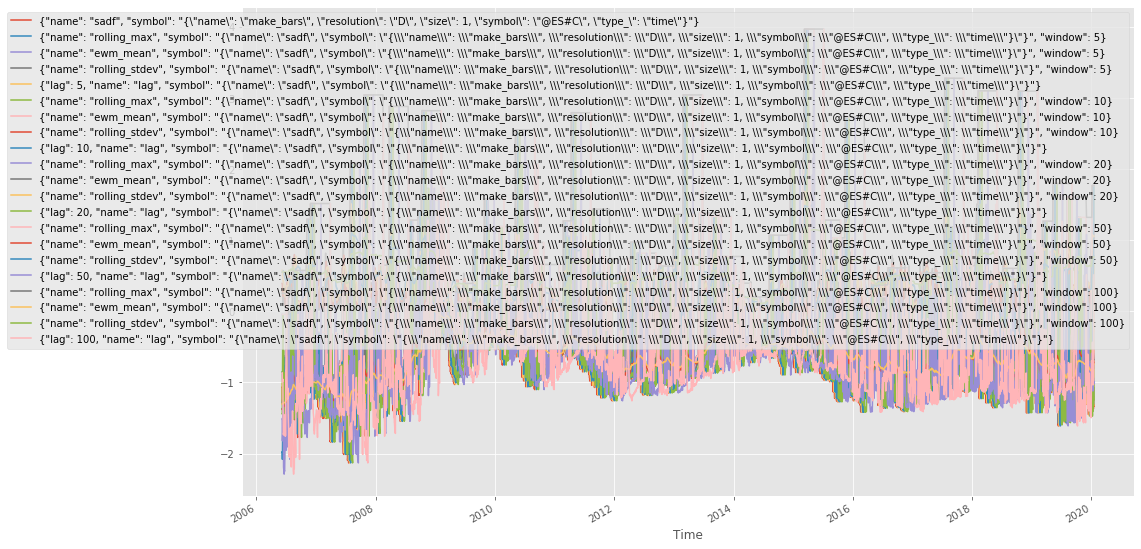

In [192]:
sadf.plot()

In [180]:
sadf = feats[c].squeeze()
price = sy["Close"]

df = pd.DataFrame({'sadf': sadf, 'price': price})
df = (df - df.min()) / (df.max() - df.min())
df['2000':'2020-6-1'].plot()

ValueError: Shape of passed values is (2, 13), indices imply (2, 55083)

In [163]:
import pandas as pd
series = pd.Series([1,2,34,4,5, 8, 9, 100, 50])
df = pd.DataFrame({'Close': series})
nplog = np.log(series).diff()






In [15]:
column = "Close"
window = 4
rolly = df[column].rolling(window)
(df[column] - rolly.mean()) / rolly.std()



0         NaN
1         NaN
2         NaN
3   -0.393518
4   -0.410702
5   -0.332907
6    1.050210
7    1.498992
8    0.189722
Name: Close, dtype: float64

In [114]:
dd = series.astype(str)

In [140]:
majority = lambda x:np.sum(x)
df = pd.DataFrame({'a' : [1,1,1,1,1,2,1,2,2,2,2]})
# df['a'] = df['a'].rolling(3).apply(majority)
df['b'] = list('aaaababbbba')

cat = pd.Categorical(df['b'])
df['b'] = pd.Series(cat.codes).rolling(3).apply(majority, raw=True)
df['b'] = df['b'].map(pd.Series(cat.categories))
print(df)


    a    b
0   1  NaN
1   1  NaN
2   1    a
3   1    a
4   1    b
5   2    b
6   1  NaN
7   2  NaN
8   2  NaN
9   2  NaN
10  2  NaN


In [126]:
pd.Series(cat.codes)

0     0
1     0
2     0
3     0
4     1
5     0
6     1
7     1
8     1
9     1
10    0
dtype: int8

In [145]:
ss

0       NaN
1       NaN
2       NaN
3       NaN
4     some_
5     ome_s
6     me_st
7     e_str
8     _stri
9     strin
10    tring
dtype: object

In [142]:
series.rolling(3).mean()

0          NaN
1          NaN
2    12.333333
3    13.333333
4    14.333333
5     5.666667
6     7.333333
7    39.000000
8    53.000000
dtype: float64